# code2vec using bag-of-words (BOW) approaches

###  As a baseline for learning representations

VECTORIZE - Create code vectors using different strategies:

1. Word Vectors
    * Count
    * TF-IDF
    * Frequency (ratio)
    * Binary (Presence / Absence)
2. Token Vectors
    * Count
3. AST Vectors

TRAIN - Learn representations using these combinations of code vectors for a machine to differentiate between:

- correct code (code submission pass the testcases)
- wrong code (code submission fail the testcases)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
font = {'weight': 'bold', 'size': 20}
plt.rc('font', **font)

## VECTORIZE

**Programming data**: Student develop programs locally for the laboratory sheets of computer programming courses at our university. These programs are submitted by them to an automatic grading platform that runs some test cases specified by the lecturer on each program. A JSON output for those testcases and whether the program passed them or not along with the actual code is stored.

In [3]:
!ls data/raw/programming_data.json

data/raw/programming_data.json


In [4]:
dataframe = pd.read_json('data/raw/programming_data.json')

In [5]:
dataframe.head(2)

,academic_year_0,academic_year_1,correct,date,extension,ip,module,task,upload,user
0,2016,2017,True,2016-09-19 14:11:41,py,,ca277,add.py,#!/usr/bin/env python\n\na = int(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c
1,2016,2017,True,2016-09-19 14:17:33,py,,ca277,concat-lines.py,#!/usr/bin/env python\n\na = str(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c


In [6]:
'{:,}'.format(len(dataframe))

'591,707'

Grab only code submissions from Python modules:

In [7]:
PYTHON_MODULES = [
    'ca116', 
    'ca117', 
    'ca177', 
    'ca277', 
    'ca278',
]

In [8]:
dataframe = dataframe[dataframe['module'].isin(PYTHON_MODULES)]

In [9]:
'{:,}'.format(len(dataframe))

'490,820'

Target value:

In [10]:
dataframe.correct.value_counts()

False    296369
True     194451
Name: correct, dtype: int64

Remove comments:

In [11]:
import re
def remove_comments(text):
    return re.sub(re.compile('#.*?\n'), '', text)

Grab docs (code submissions) and labels (correct or not):

In [12]:
def get_docs_and_labels(df):
    _docs = []
    _labels = []
    for index in df.index:
        # Program
        code = remove_comments(
            df.at[index, 'upload']
        )
        _docs.append(code)
        # Label
        label = int(df.at[index, 'correct'])
        _labels.append(label)
    return _docs, _labels

In [13]:
docs, labels = get_docs_and_labels(dataframe)

In [14]:
'{:,}'.format(len(docs))

'490,820'

In [15]:
docs[0]

u'\na = int(raw_input())\nb = int(raw_input())\n\nprint a + b\n\n\n'

In [16]:
labels[0]

1

## 1) Programs as word vectors

In [17]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [18]:
NUM_WORDS = 2000 # Originally 231,659 words

In [19]:
t = Tokenizer(num_words=NUM_WORDS, 
              filters='\t\n', 
              lower=True, 
              split=' ', 
              char_level=False)

In [20]:
t.fit_on_texts(docs)

In [21]:
# word_counts: a dictionary of words and their counts.
t.word_counts['if'] # word count

552539

In [22]:
# document_count: an integer count of the total number of documents that were used to fit the Tokenizer.
'Number docs: {:,}'.format(t.document_count)

'Number docs: 490,820'

In [23]:
# word_index: a dictionary of words and their uniquely assigned integers.
t.word_index['if'] # index

4

In [24]:
# word_docs: a dictionary of words and how many documents each appeared in.
t.word_docs['if']

298487

### a) Count: count of each word in the document

In [25]:
encoded_docs_count = t.texts_to_matrix(docs, mode='count')

In [26]:
encoded_docs_count[0]

array([ 0.,  2.,  0., ...,  0.,  0.,  0.])

In [27]:
encoded_docs_count.shape

(490820, 2000)

In [28]:
# filename = 'data/processed/word_count'
# np.save(filename, encoded_docs_count)

### b) TF-IDF: Text Frequency-Inverse DocumentFrequency (TF-IDF) scoring for each word in the document

In [29]:
encoded_docs_tfidf = t.texts_to_matrix(docs, mode='tfidf')

In [30]:
encoded_docs_tfidf[0]

array([ 0.        ,  1.25768178,  0.        , ...,  0.        ,
        0.        ,  0.        ])

In [31]:
# np.save('data/processed/word_tfidf', encoded_docs_tfidf)

### c) Frequency: frequency of each word as a ratio of words within each document.

In [32]:
encoded_docs_freq = t.texts_to_matrix(docs, mode='freq')

In [33]:
encoded_docs_freq[0]

array([ 0. ,  0.2,  0. , ...,  0. ,  0. ,  0. ])

In [34]:
# np.save('data/processed/word_freq', encoded_docs_freq)

### d) Binary: Whether or not each word is present in the document

In [35]:
encoded_docs_binary = t.texts_to_matrix(docs, mode='binary')

In [36]:
encoded_docs_binary[0]

array([ 0.,  1.,  0., ...,  0.,  0.,  0.])

In [37]:
# np.save('data/processed/word_binary', encoded_docs_binary)

## 2) Programs as tokens

In [38]:
from tokenize import generate_tokens
from StringIO import StringIO

Generate token IDs and token words. Token IDs are more general than token words (see the "Program Vectors" notebook)

In [40]:
sample_code = '''print("Hello World!")'''

In [41]:
[(t[0], t[1]) for t in list(generate_tokens(StringIO(sample_code).readline))]

[(1, 'print'), (51, '('), (3, '"Hello World!"'), (51, ')'), (0, '')]

In [42]:
token_ids = []
token_words = []
token_labels = []
i = 0
while i < len(docs):
    doc = docs[i]
    label = labels[i]
    try:
        tokens = [(t[0], t[1]) for t in list(generate_tokens(StringIO(doc).readline))]
        # Token ID
        token_ids.append(
            [token[0] for token in tokens]
        )
        # Token
        token_words.append(
            [token[1] for token in tokens]
        )
        token_labels.append(
            label
        )
    except:
        pass
    i += 1

### a) Tokens

In [43]:
[t[0] for t in list(generate_tokens(StringIO(sample_code).readline))]

[1, 51, 3, 51, 0]

In [44]:
token_ids[0]

[54,
 1,
 51,
 1,
 51,
 1,
 51,
 51,
 51,
 4,
 1,
 51,
 1,
 51,
 1,
 51,
 51,
 51,
 4,
 54,
 1,
 1,
 51,
 1,
 4,
 54,
 54,
 0]

In [45]:
'Number encoded docs: {:,}'.format(len(token_ids))

'Number encoded docs: 472,087'

In [46]:
from keras.preprocessing.sequence import pad_sequences

In [47]:
MAX_LENGTH = 25

In [48]:
token_ids_padded = pad_sequences(token_ids, maxlen=MAX_LENGTH, padding='post')

In [52]:
token_ids_padded[9]

array([1, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

### b) Token words

In [53]:
[t[1] for t in list(generate_tokens(StringIO(sample_code).readline))]

['print', '(', '"Hello World!"', ')', '']

In [54]:
token_words[0]

[u'\n',
 u'a',
 u'=',
 u'int',
 u'(',
 u'raw_input',
 u'(',
 u')',
 u')',
 u'\n',
 u'b',
 u'=',
 u'int',
 u'(',
 u'raw_input',
 u'(',
 u')',
 u')',
 u'\n',
 u'\n',
 u'print',
 u'a',
 u'+',
 u'b',
 u'\n',
 u'\n',
 u'\n',
 '']

In [55]:
'Number encoded docs: {:,}'.format(len(token_words))

'Number encoded docs: 472,087'

In [56]:
token_docs = [
    ' '.join(array) for array in token_words
]

In [57]:
token_docs[0]

u'\n a = int ( raw_input ( ) ) \n b = int ( raw_input ( ) ) \n \n print a + b \n \n \n '

In [58]:
'Number token docs: {:,}'.format(len(token_docs))

'Number token docs: 472,087'

In [59]:
token_t = Tokenizer(num_words=NUM_WORDS, 
                    filters='\t\n', 
                    lower=False, 
                    split=' ', 
                    char_level=False)

In [60]:
token_t.fit_on_texts(token_docs)

#### i) Count: count of each token word in the document

In [61]:
encoded_word_tokens_count = token_t.texts_to_matrix(token_docs, mode='count')

In [62]:
encoded_word_tokens_count[0]

array([ 0.,  4.,  4., ...,  0.,  0.,  0.])

In [63]:
# np.save('data/processed/token_word_count', encoded_word_tokens_count)

## 3) Programs as Abstract Syntax Trees

In [65]:
# TODO

## TRAIN

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

Load matrices:

In [67]:
# encoded_docs_count = np.load('data/processed/word_count')

In [68]:
# encoded_docs_tfidf = np.load('data/processed/word_tfidf')

In [69]:
# encoded_docs_freq = np.load('data/processed/word_freq')

In [70]:
# encoded_docs_binary = np.load('data/processed/word_binary')

In [71]:
# encoded_tokens_count = np.load('data/processed/token_id_count')

In [72]:
# encoded_word_tokens_count = np.load('data/processed/token_word_count')

Combinations of BOW models to compare:

In [75]:
d = {
    'Word Count': (encoded_docs_count, labels),
    'Word TFIDF': (encoded_docs_tfidf, labels),
    'Word Freq': (encoded_docs_freq, labels),
    'Word Binary': (encoded_docs_binary, labels),
    'Token ID': (token_ids_padded, token_labels),
    'Token Count': (encoded_word_tokens_count, token_labels),
    #'AST': encoded_ast,
}

In [76]:
def score():
    
    scores = {}
    
    for name, (X, y) in d.items():
        
        print 'Features:', name
        print 'Splitting between training and test data'
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        
        print 'Declaring NB'
        nb = MultinomialNB()
        
        print 'Fitting'
        nb.fit(X_train, y_train)
        
        print 'Predicting values for test data'
        y_pred = nb.predict(X_test)
        
        print 'Scoring'
        # ACCURACY
        acc = nb.score(X_test, y_test)
        # F1
        f1 = f1_score(y_test, y_pred)
        print acc, f1
        print('Accuracy: %f, F1: %f' % (acc * 100, f1 * 100))
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        
        scores[name] = (acc, f1)
        
    return scores

In [77]:
scores = score()

Features: Token Count
Splitting between training and test data
Declaring NB
Fitting
Predicting values for test data
Scoring
0.576341375585 0.554450372582
Accuracy: 57.634138, F1: 55.445037
[[29528 26736]
 [13265 24889]]
             precision    recall  f1-score   support

          0       0.69      0.52      0.60     56264
          1       0.48      0.65      0.55     38154

avg / total       0.61      0.58      0.58     94418

Features: Word Binary
Splitting between training and test data
Declaring NB
Fitting
Predicting values for test data
Scoring
0.60323540198 0.5323246878
Accuracy: 60.323540, F1: 53.232469
[[37050 22174]
 [16774 22166]]
             precision    recall  f1-score   support

          0       0.69      0.63      0.66     59224
          1       0.50      0.57      0.53     38940

avg / total       0.61      0.60      0.61     98164

Features: Word Count
Splitting between training and test data
Declaring NB
Fitting
Predicting values for test data
Scoring
0.59442361

In [78]:
scores

{'Token Count': (0.57634137558516385, 0.55445037258156138),
 'Token ID': (0.52653095808002714, 0.47150896108195017),
 'Word Binary': (0.60323540198035941, 0.53232468780019215),
 'Word Count': (0.59442361761949392, 0.53156216540574885),
 'Word Freq': (0.60831873191801478, 0.031438143940348134),
 'Word TFIDF': (0.58739456419868796, 0.56109058202663609)}

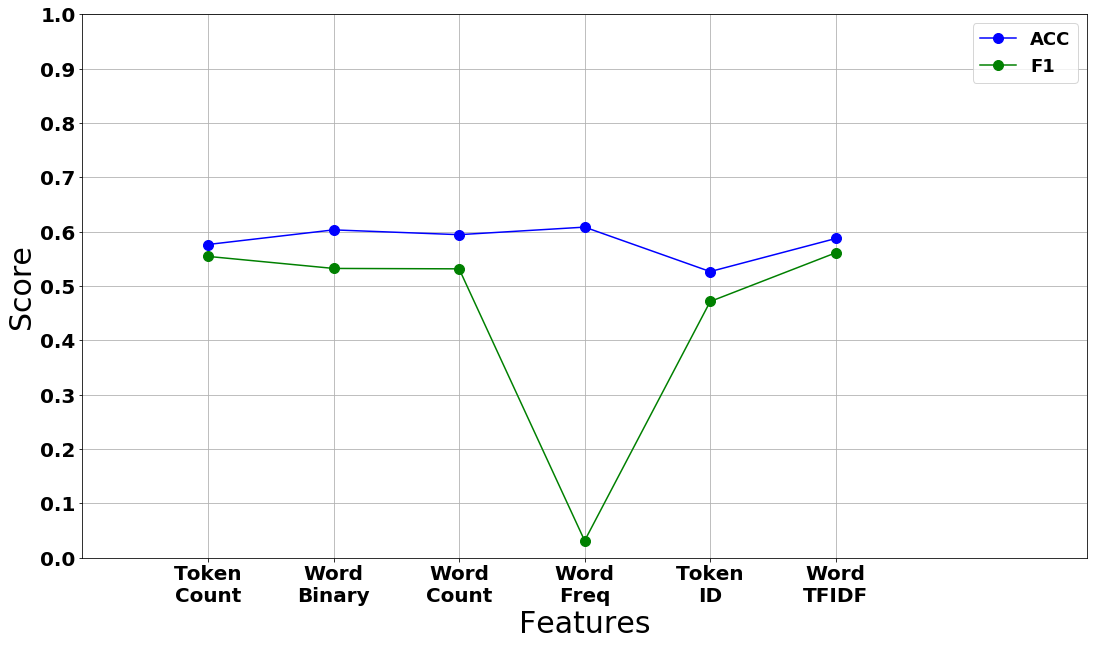

In [80]:
x = range(len(scores))
acc = [v[0] for k, v in scores.items()]
f1 = [v[1] for k, v in scores.items()]
keys = [k.replace(' ', '\n') for k, v in scores.items()]

plt.subplots(figsize=(18, 10))
plt.grid()
plt.plot(x, acc, 'o-', color='b', label='ACC', markersize=10)
plt.plot(x, f1, 'o-', color='green', label='F1', markersize=10)
plt.ylabel('Score', fontsize=30)
plt.xlabel('Features', fontsize=30)
plt.xlim([-1, len(scores) + 1])
plt.xticks(x, keys)
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="upper right", fontsize=18)